In [1]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
import mne

import seaborn as sns
import matplotlib.pyplot as plt

from utils import *
from connectivity_dynamics import *

In [2]:
TIMELINE_F = '/mnt/ernie_main/000_Data/SEEG/SEEG_Periictal/data/Extracted_Per_Event_Interictal/all_time_data_01042023_212306.csv'
SEEG_FOLDER = '/mnt/ernie_main/000_Data/SEEG/SEEG_Entire_EMU_Downloads/data/'

In [3]:
seeg_timeline_df = pd.read_csv(TIMELINE_F, delimiter="\t")
seeg_timeline_df.head(5)

,Type,Pat ID,Event Number (Matches EMU Final Report),Date (MM:DD:YYYY),Onset String (HH:MM:SS),Offset String (HH:MM:SS),Seizure Type (FAS; FIAS; FBTC; Non-electrographic; Subclinical; Unknown),FileIndex,onset_datetime,offset_datetime,onset_datetime_buffer,offset_datetime_buffer,FileName
0,File,Epat02,File1,09:14:2017,13:05:11,17:05:11,NaN,0,2017-09-14 13:05:11,2017-09-14 17:05:11,2017-09-14 13:06:11,2017-09-14 17:04:11,Epat02_09142017_13051100.EDF
1,File,Epat02,File2,09:14:2017,17:05:22,21:05:22,NaN,1,2017-09-14 17:05:22,2017-09-14 21:05:22,2017-09-14 17:06:22,2017-09-14 21:04:22,Epat02_09142017_17052200.EDF
2,File,Epat02,File3,09:14:2017,21:05:34,01:05:34,NaN,2,2017-09-14 21:05:34,2017-09-15 01:05:34,2017-09-14 21:06:34,2017-09-15 01:04:34,Epat02_09142017_21053400.EDF
3,File,Epat02,File4,09:15:2017,01:05:45,05:05:45,NaN,3,2017-09-15 01:05:45,2017-09-15 05:05:45,2017-09-15 01:06:45,2017-09-15 05:04:45,Epat02_09152017_01054500.EDF
4,File,Epat02,File5,09:15:2017,05:05:56,09:05:56,NaN,4,2017-09-15 05:05:56,2017-09-15 09:05:56,2017-09-15 05:06:56,2017-09-15 09:04:56,Epat02_09152017_05055600.EDF


In [3]:
label_f = '~/Ephys/Data/all_pats_bipole_soz_labels.csv'
label_df = pd.read_csv(label_f, header=None)
label_df.columns = ['subj','bipole','label']



label_df = split_bipole(label_df)

label_df.label = label_df.label.apply(map_label)
label_df['bipole'] = label_df.bipole.apply(lambda x: x.replace(" ", ""))

# Calculating Connectivity Between Channels

It seems my task is much easier than I previously thought. There are designated recordings for my 4 periods of interested already cleaned and labelled by Derek and Graham. Bless.

Goal for this section's exploration: calculate ISH across 4 periods for 1 patient.
1. Find 4 recordings for patient
1. Calc Connectivity (PDC) for each recording
1. Im show some of those recordings
1. calculate inward-outward strengh for 4 periods - ISH
1. BONUS: Redo 1-4 with cross spectral coherence connectivity from the French

## Using Precomputed PDC Peri-Ictally

In [4]:
data_dir = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/'
folders = glob.glob(os.path.join(data_dir, "*pat*"))
sub_ids = [os.path.basename(f) for f in folders]

In [5]:
tst_folders = folders[0:2]
tst_subj = sub_ids[0:2]

In [57]:
tst_df = agg_subjects(folders[0:2], sub_ids[0:2], label_df,filter_dist=20)

In [58]:
tst_df

,subj,period,region,net_pdc,freq_band,conn_file
0,Epat02,inter,soz,0.711499,delta,Epat02_10_FIAS_imcoh.mat
1,Epat02,inter,pz,0.064549,delta,Epat02_10_FIAS_imcoh.mat
2,Epat02,inter,nz,-0.046119,delta,Epat02_10_FIAS_imcoh.mat
3,Epat02,inter,soz,0.735838,theta,Epat02_10_FIAS_imcoh.mat
4,Epat02,inter,pz,0.063382,theta,Epat02_10_FIAS_imcoh.mat
...,...,...,...,...,...,...
67,Epat03,post,pz,-1.265300,gamma_l,Epat03_8_FIAS_imcoh.mat
68,Epat03,post,nz,0.248214,gamma_l,Epat03_8_FIAS_imcoh.mat
69,Epat03,post,soz,-0.122508,gamma_H,Epat03_8_FIAS_imcoh.mat
70,Epat03,post,pz,-1.643212,gamma_H,Epat03_8_FIAS_imcoh.mat


In [60]:

full_peri_ictal_df = agg_subjects(folders, sub_ids, label_df,filter_dist=20)

/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:125: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:125: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:125: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:125: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:125: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:125: RuntimeWarning: Mean of empty slice
  net_pz = np.nanmean(pz_in) - np.nanmean(pz_out)
/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivi

In [65]:
full_peri_ictal_df

,subj,period,region,net_pdc,freq_band,conn_file
0,Epat02,inter,soz,0.711499,delta,Epat02_10_FIAS_imcoh.mat
1,Epat02,inter,pz,0.064549,delta,Epat02_10_FIAS_imcoh.mat
2,Epat02,inter,nz,-0.046119,delta,Epat02_10_FIAS_imcoh.mat
3,Epat02,inter,soz,0.735838,theta,Epat02_10_FIAS_imcoh.mat
4,Epat02,inter,pz,0.063382,theta,Epat02_10_FIAS_imcoh.mat
...,...,...,...,...,...,...
67,Spat52,post,pz,-0.271489,gamma_l,Spat52_7_FIAS_imcoh.mat
68,Spat52,post,nz,0.066112,gamma_l,Spat52_7_FIAS_imcoh.mat
69,Spat52,post,soz,-0.541280,gamma_H,Spat52_7_FIAS_imcoh.mat
70,Spat52,post,pz,-0.325937,gamma_H,Spat52_7_FIAS_imcoh.mat


In [66]:
full_peri_ictal_df.to_csv("../data/peri_ictal_conn_excl_dist.csv",index=False)

In [6]:
full_df = pd.read_csv("../data/peri_ictal_conn_excl_dist.csv")

## Analyzing Peri Ictal Dynamics

In [7]:
peri_ictal_df = full_df[['subj','period','region','net_pdc','freq_band']]

In [8]:
peri_stats_df = peri_ictal_df.groupby(['subj', 'period', 'freq_band','region']).mean()

/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a 

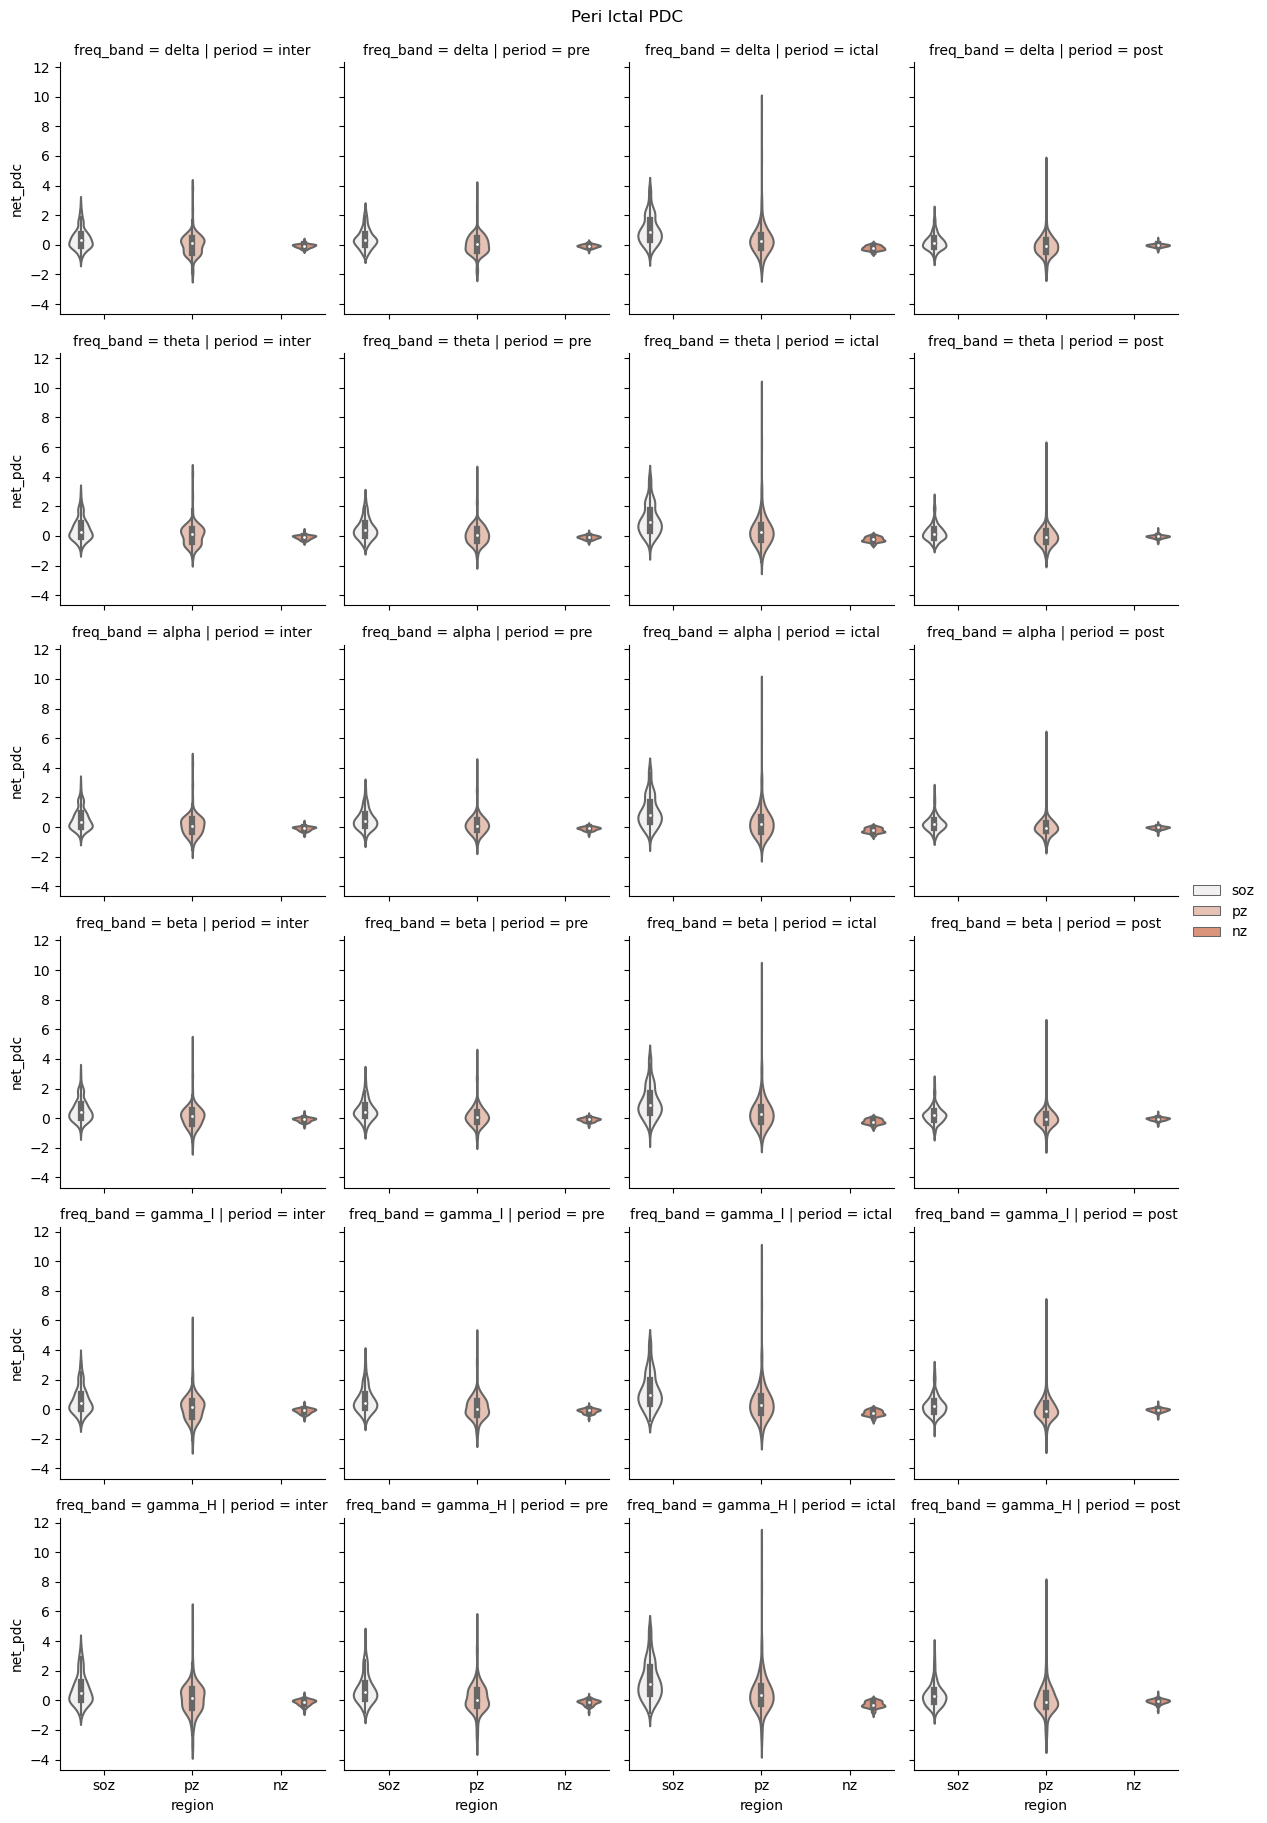

In [18]:
# alpha_peri_df.groupby(['subj','period','region']).mean().reset_index()
with sns.color_palette("flare"):
    grid = sns.FacetGrid(peri_ictal_df,col='period', row='freq_band',col_order=['inter','pre','ictal','post']) 
    grid.map_dataframe(sns.violinplot, y='net_pdc',x='region', positions=[1,2,3], hue='region')
    grid.add_legend()
    grid.figure.suptitle("Peri Ictal PDC",y=1.01)


## ISH OG Cohort

In [71]:
og_ISH = load_mat('/mnt/ernie_main/PCA_project/data/original_81_structs/PDC_pats.mat')

ish_subj_df = pd.read_csv('../data/ish_subid.csv',header=None)
ish_subj_df.columns = ['og_id']

In [224]:
ish_subj_df['subj_id'] = ish_subj_df.og_id.apply(lambda x : x.split("_")[0])
common_ids = set(ish_subj_df.subj_id).intersection(sub_ids)
len(common_ids) == len(sub_ids) 
#Sanity check to make sure that I have all the
#peri ictal cohort in the ISH cohort. Should be True

True

In [225]:
#Next I need to make sure that my SOZ designations in the ISH cohort are the same
# as the SOZ designation in the Peri=ictal cohort
def map_num_soz(l:int, remap_iz =False)->str:
    """Returns label for each number following this convention
            # 0 - NIZ 
            # 1 - SOZ 
            # 2 - PZ
            # 3 - IZ
    Args:
        l (int): soz designation code found in structs

    Returns:
        str: string designation of 'SOZ', 'NIZ', etc
    """
    match l:
        case 0:
            return "NIZ"
        case 1:
            return "SOZ"
        case 2: 
            return "PZ"
        case 3:
            if remap_iz:
                return "NIZ"
            return "IZ"
sub_num = 0
epat_26_labels = og_ISH['pats']['SOZ'][0,sub_num]
epat_26_labels = np.array([map_num_soz(l) for l in epat_26_labels])
epat_26_labels

array(['SOZ', 'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'PZ', 'PZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ',
       'SOZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ', 'SOZ', 'SOZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ', 'NIZ', 'SOZ', 'SOZ', 'SOZ', 'NIZ', 'NIZ',
       'NIZ', 'NIZ', 'NIZ'], dtype='<U3')

In [226]:

epat_26_f = '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat26/Epat26_3_FIAS_imcoh.mat'
epat_26_obj = load_mat(epat_26_f)

pat_df = label_df[label_df.subj == 'Epat26']
regions = get_regions(pat_df, epat_26_obj,'Epat26')

##IF this is true then there is no issue in my designations of SOZ PZ
np.where(regions == epat_26_labels)[0].shape[0] == regions.shape[0]

In [229]:
for i, obj in enumerate(og_ISH['pats'][0]):
    print(type(obj['long_Z'].shape))
    print(obj['long_Z'][4][0].shape)
     print([map_num_soz(l) for l in obj['SOZ']])


(5, 1)
(103, 103)
(5, 1)
(95, 95)
(5, 1)
(94, 94)
(5, 1)
(58, 58)
(5, 1)
(108, 108)
(5, 1)
(77, 77)
(5, 1)
(124, 124)
(5, 1)
(109, 109)
(5, 1)
(75, 75)
(5, 1)
(55, 55)
(5, 1)
(112, 112)
(5, 1)
(67, 67)
(5, 1)
(86, 86)
(5, 1)
(78, 78)
(5, 1)
(111, 111)
(5, 1)
(89, 89)
(5, 1)
(92, 92)
(5, 1)
(74, 74)
(5, 1)
(134, 134)
(5, 1)
(73, 73)
(5, 1)
(109, 109)
(5, 1)
(69, 69)
(5, 1)
(43, 43)
(5, 1)
(63, 63)
(5, 1)
(51, 51)
(5, 1)
(38, 38)
(5, 1)
(42, 42)
(5, 1)
(67, 67)
(5, 1)
(52, 52)
(5, 1)
(69, 69)
(5, 1)
(100, 100)
(5, 1)
(124, 124)
(5, 1)
(70, 70)
(5, 1)
(113, 113)
(5, 1)
(96, 96)
(5, 1)
(71, 71)
(5, 1)
(84, 84)
(5, 1)
(94, 94)
(5, 1)
(76, 76)
(5, 1)
(105, 105)
(5, 1)
(117, 117)
(5, 1)
(72, 72)
(5, 1)
(113, 113)
(5, 1)
(59, 59)
(5, 1)
(76, 76)
(5, 1)
(26, 26)
(5, 1)
(42, 42)
(5, 1)
(120, 120)
(5, 1)
(42, 42)
(5, 1)
(141, 141)
(5, 1)
(83, 83)
(5, 1)
(94, 94)
(5, 1)
(88, 88)
(5, 1)
(126, 126)
(5, 1)
(68, 68)
(5, 1)
(126, 126)
(5, 1)
(90, 90)
(5, 1)
(118, 118)
(5, 1)
(136, 136)
(5, 1)
(111, 111

80

In [228]:
ish_conn_df = struct_to_pat_df(og_ISH, ish_subj_df.subj_id)

Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_188529/921412779.py", line 1, in <module>
    ish_conn_df = struct_to_pat_df(og_ISH, ish_subj_df.subj_id)
                  ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ghassan/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py", line 241, in struct_to_pat_df
    conn_mat = long_to_mat(obj)
               ^^^^^^^^^^^
NameError: name 'long_to_mat' is not defined

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ghassan/miniconda3/envs/ephys/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 2120, in showtraceback
    stb = self.InteractiveTB.structured_traceback(
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/ghassan/miniconda3/